## Transfer Learning approach

## import the libraries 

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

## Re-size all images to this 224 as transfer learning default use 224

In [2]:
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'


## Import the ResNet50 library and add preprocessing layer to the front of Resnet
### Here we will be using imagenet weights

In [3]:


resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




94773248/94765736 [==============================] - 38s 0us/step


In [4]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

## useful for getting number of output classes

In [14]:
folders = glob('Datasets/train/*')
folders

['Datasets/train\\audi',
 'Datasets/train\\ferrari',
 'Datasets/train\\lamborghini',
 'Datasets/train\\mercedes']

## our layers - we can add more if we want

Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer

In [15]:
x = Flatten()(resnet.output)
x

<tf.Tensor 'flatten_1/Identity:0' shape=(None, 100352) dtype=float32>

## Predection layer

In [7]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

## Structure of the model

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
# Decide cost and optimization method 
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


## Import images and rescale images

In [10]:
# Use  Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 78 images belonging to 4 classes.


In [12]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 66 images belonging to 4 classes.


## fit model

In [13]:
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3 steps, validate for 3 steps
Epoch 1/50
3/3 [==============================] - 22s 7s/step - loss: 7.9231 - accuracy: 0.3077 - val_loss: 12.2166 - val_accuracy: 0.1364
Epoch 2/50
3/3 [==============================] - 19s 6s/step - loss: 7.3473 - accuracy: 0.2949 - val_loss: 3.0323 - val_accuracy: 0.2879
Epoch 3/50
3/3 [==============================] - 16s 5s/step - loss: 4.6163 - accuracy: 0.3205 - val_loss: 2.3594 - val_accuracy: 0.4242
Epoch 4/50
3/3 [==============================] - 19s 6s/step - loss: 3.6078 - accuracy: 0.4103 - val_loss: 1.4254 - val_accuracy: 0.4545
Epoch 5/50
3/3 [==============================] - 19s 6s/step - loss: 2.3183 - accuracy: 0.3333 - val_loss: 3.8899 - val_accuracy: 0.2576
Epoch 6/50
3/3 [==============================] - 21s 7s/step - loss: 2.8757 - accuracy: 0.4744 - val_loss: 2.5790 - val_accuracy: 0.2424
Epoch

## plot the loss

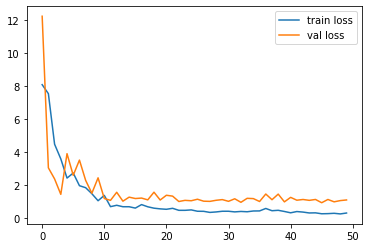

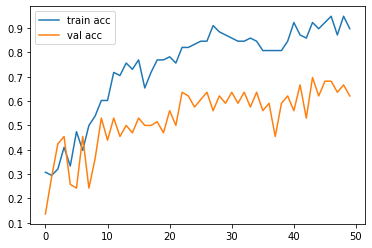

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## save model as a h5 file

In [17]:
from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

## Prediction

In [18]:
y_pred = model.predict(test_set)
y_pred

array([[2.04468612e-02, 2.61320500e-03, 9.67985272e-01, 8.95457249e-03],
       [1.08500443e-01, 1.56705305e-01, 5.58052123e-01, 1.76742181e-01],
       [1.31805091e-05, 9.81047571e-01, 2.43972623e-04, 1.86953302e-02],
       [1.55737311e-01, 3.19109440e-01, 1.88642815e-02, 5.06289005e-01],
       [1.48752064e-01, 3.63383532e-01, 1.40115008e-01, 3.47749382e-01],
       [2.58821398e-01, 5.27819656e-02, 6.27317131e-01, 6.10795505e-02],
       [4.28910134e-03, 8.67559671e-01, 3.43821235e-02, 9.37691182e-02],
       [2.36784101e-01, 5.72507381e-02, 7.63682798e-02, 6.29596889e-01],
       [8.00875366e-01, 7.29200095e-02, 1.24192856e-01, 2.01178412e-03],
       [7.53199607e-02, 1.59871560e-02, 6.55053377e-01, 2.53639460e-01],
       [9.34556276e-02, 1.16966136e-01, 3.04297335e-03, 7.86535263e-01],
       [8.15667510e-02, 1.39968542e-05, 9.08385217e-01, 1.00339092e-02],
       [1.22121103e-01, 1.06338402e-02, 7.89658260e-03, 8.59348536e-01],
       [3.01824380e-02, 1.56476796e-02, 7.49212861e

## convert probability to choose the highest probability class as result

In [19]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [20]:
y_pred

array([2, 2, 1, 3, 1, 2, 1, 3, 0, 2, 3, 2, 3, 2, 1, 3, 0, 3, 1, 0, 2, 2,
       2, 2, 2, 1, 2, 3, 2, 1, 1, 1, 2, 0, 2, 1, 0, 1, 2, 2, 0, 2, 3, 3,
       2, 2, 0, 3, 2, 3, 2, 2, 2, 0, 3, 2, 2, 2, 0, 2, 0, 1, 2, 1, 2, 3],
      dtype=int64)

## Load the model and check prediction on test data

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [22]:
model=load_model('model_resnet50.h5')

In [24]:
img=image.load_img('Datasets/Test/lamborghini/11.jpg',target_size=(224,224))

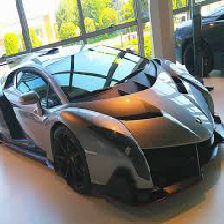

In [26]:
img

In [27]:
x=image.img_to_array(img)
x

array([[[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [196., 187., 172.],
        [217., 208., 193.],
        [243., 234., 219.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [245., 245., 237.],
        [243., 243., 235.],
        [242., 242., 234.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [240., 249., 248.],
        [242., 251., 250.],
        [242., 251., 250.]],

       ...,

       [[189., 207., 229.],
        [190., 206., 229.],
        [190., 206., 229.],
        ...,
        [171., 180., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [185., 206., 227.],
        ...,
        [171., 180., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [185., 2

In [28]:
x.shape

(224, 224, 3)

In [29]:
x=x/255

In [30]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [31]:
model.predict(img_data)

array([[1.5190723e-03, 9.9169608e-07, 3.7922695e-02, 9.6055728e-01]],
      dtype=float32)

In [35]:
a=np.argmax(model.predict(img_data), axis=1)
a

array([3], dtype=int64)